In [4]:
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import os

from keras.models import Sequential
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model

from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input



In [2]:
from keras.applications.efficientnet import EfficientNetB7

In [20]:
IMAGE_SIZE = [224, 224]

train_path = os.path.join(os.getcwd(),'data','transfer-lr-ds','train')
valid_path = os.path.join(os.getcwd(),'data','transfer-lr-ds','test')

In [6]:
vgg = EfficientNetB7(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

258088960/258076736 [==============================] - 43s 0us/step


In [7]:
for layer in vgg.layers:
    layer.trainable = False

In [8]:
x = Flatten()(vgg.output)

In [9]:
folders = glob(os.path.join(train_path,'*'))

In [10]:
len(folders)

4

In [11]:
output_layer = Dense(len(folders), activation='softmax')(x)

In [12]:
model = Model(inputs=vgg.input, outputs=output_layer)

In [13]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 224, 224, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 stem_conv_pad (ZeroPadding2D)  (None, 225, 225, 3)  0           ['normalization[0][0]']      

                                                                                                  
 block4j_se_reduce (Conv2D)     (None, 1, 1, 40)     38440       ['block4j_se_reshape[0][0]']     
                                                                                                  
 block4j_se_expand (Conv2D)     (None, 1, 1, 960)    39360       ['block4j_se_reduce[0][0]']      
                                                                                                  
 block4j_se_excite (Multiply)   (None, 14, 14, 960)  0           ['block4j_activation[0][0]',     
                                                                  'block4j_se_expand[0][0]']      
                                                                                                  
 block4j_project_conv (Conv2D)  (None, 14, 14, 160)  153600      ['block4j_se_excite[0][0]']      
                                                                                                  
 block4j_p

                                                                                                  
 block6f_se_squeeze (GlobalAver  (None, 2304)        0           ['block6f_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block6f_se_reshape (Reshape)   (None, 1, 1, 2304)   0           ['block6f_se_squeeze[0][0]']     
                                                                                                  
 block6f_se_reduce (Conv2D)     (None, 1, 1, 96)     221280      ['block6f_se_reshape[0][0]']     
                                                                                                  
 block6f_se_expand (Conv2D)     (None, 1, 1, 2304)   223488      ['block6f_se_reduce[0][0]']      
                                                                                                  
 block6f_s

In [14]:
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [15]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

training_set = train_datagen.flow_from_directory(train_path,
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

test_set = test_datagen.flow_from_directory(valid_path,
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical')

Found 84 images belonging to 4 classes.
Found 7 images belonging to 4 classes.


In [16]:
r = model.fit(
  training_set,
  validation_data=test_set,
  epochs=5,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set)
)

Epoch 1/5
3/3 [==============================] - 86s 18s/step - loss: 40.3302 - accuracy: 0.2619 - val_loss: 96.1001 - val_accuracy: 0.1429
Epoch 2/5
3/3 [==============================] - 47s 14s/step - loss: 46.7380 - accuracy: 0.2857 - val_loss: 45.4916 - val_accuracy: 0.4286
Epoch 3/5
3/3 [==============================] - 47s 17s/step - loss: 42.7514 - accuracy: 0.3214 - val_loss: 52.3749 - val_accuracy: 0.2857
Epoch 4/5
3/3 [==============================] - 46s 13s/step - loss: 62.2610 - accuracy: 0.1429 - val_loss: 78.2039 - val_accuracy: 0.1429
Epoch 5/5
3/3 [==============================] - 43s 12s/step - loss: 49.3564 - accuracy: 0.3452 - val_loss: 46.8358 - val_accuracy: 0.1429


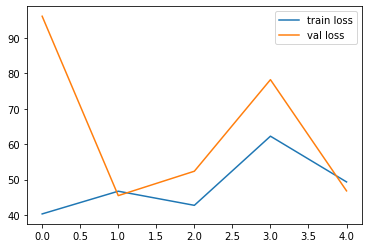

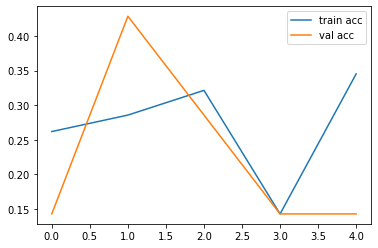

<Figure size 432x288 with 0 Axes>

In [17]:
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# accuracies
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')